<a href="https://colab.research.google.com/github/romitbarua/MultiModalDeepFake/blob/main/TestingNotebooks/PCAvsMFCC.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
#### Articles Used to Generate Code
#https://towardsdatascience.com/eigenfaces-recovering-humans-from-ghosts-17606c328184
#https://machinelearningmastery.com/face-recognition-using-principal-component-analysis/

In [2]:
#mount the google drive
from google.colab import drive
drive.mount('/content/drive/')

Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).


In [3]:
#import appropriate packages
import os
import cv2
import dlib
from google.colab.patches import cv2_imshow
import numpy as np 
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import librosa
from scipy.io import wavfile
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
import pandas as pd
import seaborn as sns
from sklearn.ensemble import RandomForestRegressor
import itertools

In [4]:
SYM_PATH = '/content/drive/MyDrive/DeepFakeDetection'
%cd $SYM_PATH
%pip install -e .

/content/drive/MyDrive/DeepFakeDetection
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Obtaining file:///content/drive/MyDrive/DeepFakeDetection
  Attempting uninstall: DeepFake
    Found existing installation: DeepFake 0.1.0
    Can't uninstall 'DeepFake'. No files were found to uninstall.
  Running setup.py develop for DeepFake


In [5]:
#import custom packages
from packages.DlibManager import DlibManager

# Functions

In [6]:
def normalize(data, debug_mode = False):
  if debug_mode:
    print('NORMALIZE DATA')
    print('Data Shape: ', data.shape)
    print('Data Type: ', type(data.dtype))
    print('Mean Shape:', np.mean(data, axis=0).shape)
    print('Std Shape:', np.mean(data, axis=0).shape)
    print('------------------------------')
  return (data - np.mean(data, axis=0))/np.std(data, axis=0)

In [7]:
#source: https://stackoverflow.com/questions/2566412/find-nearest-value-in-numpy-array
def find_nearest_idx(array, value):
  array = np.asarray(array)
  return (np.abs(array - value)).argmin()
  

In [8]:
def load_dlib_objects(predictor_path='/content/drive/MyDrive/DeepFakeDetection/model/shape_predictor_68_face_landmarks.dat'):
  detector = dlib.get_frontal_face_detector()
  predictor = dlib.shape_predictor(predictor_path)
  return detector, predictor

In [9]:
def match_mfcc_dlib(mfccs, dlib_frames, duration, win_time, hop_time, debug_mode=False):

  win_time = win_time/1000
  hop_time = hop_time/1000

  mfcc_times = np.arange(0, mfccs.shape[0], 1)*(hop_time)+0.5*win_time
  
  second_per_frame = duration/len(dlib_frames)
  dlib_frame_times = np.arange(0, len(dlib_frames), 1)*second_per_frame

  new_dlib_frames = [dlib_frames[find_nearest_idx(dlib_frame_times, time)] for time in mfcc_times]
  
  return new_dlib_frames


In [10]:
def return_dlib_items(video_path, return_items, detector, predictor, lip_extension, debug_mode=False):

  assert return_items in ['lips']

  video = cv2.VideoCapture(video_path)
  dlib_video = DlibManager(predictor, detector, video, lip_extension_pixels=lip_extension)
  video.release()

  if debug_mode:
    print('Successfully loaded the Dlib Video')

  if return_items == 'lips':
    if debug_mode:
      print('Returning Lip Frames')
      print('Number of Lip Frames: ', len(dlib_video.lip_frames))
    return dlib_video.lip_frames
  else:
    return -1



In [11]:
def return_mfccs(audio_path, sample_rate, window_time, hop_time, mfcc_frames, n_mfcc, delta_order, normalize_mfcc=True, debug_mode=False):

  audio, _ = librosa.load(audio_path, sr=sample_rate)
  audio_duration = librosa.get_duration(audio)

  win_length = int(sample_rate/1000 * window_time)
  hop_length = int(sample_rate/1000 * hop_time)

  mfcc = librosa.feature.mfcc(audio, n_mfcc=n_mfcc, win_length=win_length, hop_length=hop_length)

  if delta_order > 0:
    mfcc = librosa.feature.delta(mfcc, order=delta_order)

  mfcc = mfcc.T

  if normalize_mfcc:
    mfcc = normalize(mfcc, debug_mode)

  return mfcc, audio_duration




In [12]:
#load the training data from the disk
def load_FakeAvCeleb_mfcc_lip_data(metadata, ids, video_method, sample=False, audio_sample_rate=22050, window_time=25, hop_time=10, n_mfcc=12, delta_order = 0, debug_mode=False):

  detector, predictor = load_dlib_objects()
  
  video_details = {}
  failed_to_load = []

  for idx, id in enumerate(ids):
    print(f'\rVideo #{idx+1} out of {len(ids)}', end="")

    if not sample:
      video_path = metadata[(metadata['source'] == id) & (metadata['method'] == video_method)]['full_path'].values[0]
    else:
      video_path = metadata[(metadata['source'] == id) & (metadata['method']==video_method)].sample(1)['full_path'].values[0]

    audio_path = video_path.replace('.mp4', '.wav')

    #run the functions outside of the try except block
    if debug_mode:
      lip_frames = return_dlib_items(video_path, 'lips', detector, predictor, debug_mode)
      mfcc, duration = return_mfccs(audio_path, audio_sample_rate, window_time, hop_time, len(lip_frames), n_mfcc=n_mfcc, delta_order=delta_order)
      print('Shape of MFCC: ', mfcc.shape)
      print('Shape of Dlib Frames: ', len(lip_frames))
      lip_frames = match_mfcc_dlib(mfcc, lip_frames, duration)
      print('Expanded DLib Frames to Match MFCC Frames')
      print('Expanded Dlib Frame Shape: ', len(lip_frames))


    try:
      lip_frames = return_dlib_items(video_path, 'lips', detector, predictor, debug_mode)

      mfcc, duration = return_mfccs(audio_path, audio_sample_rate, window_time, hop_time, len(lip_frames), n_mfcc=n_mfcc, delta_order=delta_order)
      
      lip_frames = match_mfcc_dlib(mfcc, lip_frames, duration, window_time, hop_time)

      video_details[id] = [video_path, lip_frames, mfcc]

    except:
      #print(f'Failed to Upload: {id}')
      failed_to_load.append(video_path)

  return video_details

In [13]:
def load_single_subject_mfcc_lip_data(id_paths, audio_sample_rate=22050, window_time=25, hop_time=10, n_mfcc=12, delta_order=0, lip_extension=5, debug_mode=False):

  detector, predictor = load_dlib_objects()
  
  video_details = {}
  failed_to_load = []

  for idx, id_path in enumerate(id_paths):
    print(f'\rVideo #{idx+1} out of {len(id_paths)}', end="")
    
    video_path = id_path
    audio_path = video_path.replace('.mp4', '.wav')

    lip_frames = return_dlib_items(video_path, 'lips', detector, predictor, lip_extension=lip_extension, debug_mode=debug_mode)
    mfcc, duration = return_mfccs(audio_path, audio_sample_rate, window_time, hop_time, len(lip_frames), n_mfcc=n_mfcc, delta_order=delta_order)
    lip_frames = match_mfcc_dlib(mfcc, lip_frames, duration, window_time, hop_time)
    video_details[id_path] = [video_path, lip_frames, mfcc]


  if debug_mode:
    print('Number of Videos Loaded: ', len(list(video_details.keys())))
  return video_details




In [14]:
def load_mfcc_lip_data(id_paths, audio_sample_rate=22050, window_time=25, hop_time=10, n_mfcc=12, delta_order=0, lip_extension=5, debug_mode=False):

  detector, predictor = load_dlib_objects()
  
  video_details = []
  failed_to_load = []

  for idx, id_path in enumerate(id_paths):
    print(f'\rVideo #{idx+1} out of {len(id_paths)}', end="")
    
    video_path = id_path
    audio_path = video_path.replace('.mp4', '.wav')

    lip_frames = return_dlib_items(video_path, 'lips', detector, predictor, lip_extension=lip_extension, debug_mode=debug_mode)
    mfcc, duration = return_mfccs(audio_path, audio_sample_rate, window_time, hop_time, len(lip_frames), n_mfcc=n_mfcc, delta_order=delta_order)
    lip_frames = match_mfcc_dlib(mfcc, lip_frames, duration, window_time, hop_time)
    video_details.append([video_path, lip_frames, mfcc])


  if debug_mode:
    print('Number of Videos Loaded: ', len(list(video_details.keys())))
  return video_details


In [15]:
def prep_images_for_pca(frames, grey_image=True, height=60, width=70):

  processed_frames = []

  for frame in frames:
    if grey_image:
      frame = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
    frame = cv2.resize(frame, (height, width))
    processed_frames.append(frame)

  num_frames = len(processed_frames)
  processed_frames = np.array(processed_frames).reshape(num_frames, height*width)

  return processed_frames


In [16]:
def run_pca(data, num_components, fit, data_mean=None, pca=None, debug_mode=False):

  assert ((fit == False and not isinstance(data_mean, type(None)) and not isinstance(pca, type(None))) or fit), "Must provide a data_mean if you are reversing"

  if debug_mode:
    print('Running PCA:')
    print('Data Shape: ', data.shape)
    print()

  if fit:
    data_mean = np.mean(data, axis=0)
    data_centered = data - data_mean

    pca = PCA(n_components=num_components)
    pca_data = pca.fit_transform(data_centered)

  else:
    data_centered = data - data_mean
    pca_data = pca.transform(data_centered)

  weights = np.dot(data_centered, pca.components_[:num_components].T)

  return pca, weights, data_mean, data_centered

In [17]:
def generate_mfcc_pca_lips_X_y_data(video_details, fit_pca, num_components=10, pca=None, data_mean=None, debug_mode = False):
  
  lips_data = None
  X  = None
  y = None

  if debug_mode:
    print('Generating X & y for the training data:')
    print('Size of Video Details: ', len(video_details))

  for idx, video_data in enumerate(video_details):

    if debug_mode:
      print(f'Running #{idx+1} of {len(video_details)}')
      print('Items to Unpack: ', len(video_details))

    video_path, lip_frames, mfcc = video_data

    if debug_mode:
      print('Number of Lip Frames: ', len(lip_frames))
      print('Shape of Lip 1: ', lip_frames[0].shape)

    pca_ready_lips = prep_images_for_pca(lip_frames)

    if debug_mode:
      print('PCA Processed Lips Shape: ', pca_ready_lips.shape)

    if isinstance(lips_data, type(None)):
      lips_data = pca_ready_lips
      y = mfcc
    else:
      lips_data = np.vstack((lips_data, pca_ready_lips))
      y = np.vstack((y, mfcc))

  if debug_mode:
    print('Shape of Lips Data: ', lips_data.shape)

  video_details = None

  if debug_mode:
    'Starting to Run PCA'

  pca, weights, lips_data_mean, data_centered = run_pca(lips_data, num_components, fit_pca, data_mean, pca, debug_mode=debug_mode)

  X = weights

  return X, y, lips_data_mean, pca, lips_data


In [18]:
def display_eigenfaces(pca, num_components):
  #show the eigenfaces
  eigenfaces = pca.components_[:num_components]
  
  # Show the first 16 eigenfaces
  fig, axes = plt.subplots(2,5,figsize=(16,8))
  idx = 0
  for i in range(5):
    for j in range(2):
      axes[j][i].imshow(eigenfaces[idx].reshape((70, 90)), cmap="gray")
      idx += 1
  plt.show()

In [19]:
def pca_image_reconstruction(pca, centered_image, image_mean, num_components=10, width=70, height=60, image_idx=0):
  
  eigenfaces = pca.components_[:num_components]
  samples, features = centered_image.shape
  weights = np.dot(centered_image, eigenfaces.T)
  recovered_image = (np.dot(weights[image_idx,:], eigenfaces)+image_mean).reshape(width, height)
  return recovered_image



In [20]:
def train_models(X, y, model_type='LinearRegression'):

  num_coef = y.shape[1]
  models = []
  for i in range(num_coef):
    assert X.shape[0] == y[:, i].shape[0], 'X and y must have the same number of rows'
    
    if model_type == 'LinearRegression':
      model = LinearRegression()
    elif model_type == 'RandomForest':
      model = RandomForestRegressor()
    model.fit(X, y[:, i])
    models.append(model)

  return models

In [21]:
def eval_test_data(test_video_details, models, data_mean, pca,  num_components, components=None, debug_mode=False):

  #store the average per video mean squared error
  video_error = []

  for idx, video_data in enumerate(test_video_details):

    #if key not in fake_testing_details.keys():
    #  continue

    X_test, y_test, lips_data_mean, pca, lip_data_real = generate_mfcc_pca_lips_X_y_data([video_data], fit_pca=False, data_mean=data_mean, pca=pca, num_components=num_components, debug_mode=debug_mode)

    if not isinstance(components, type(None)):
      X_test = X_test[:, components]

    #store error for each coefficient
    mfcc_errors = []

    if debug_mode:
      print(f'Training Models for Video {idx} out of {len(real_testing_details.keys())}')

    for idx, model in enumerate(models):
      y_pred = model.predict(X_test)

      err = mean_squared_error(y_true=y_test[:, idx], y_pred=y_pred)

      mfcc_errors.append(err)

    real_video_error.append(np.mean(mfcc_errors))

  return video_error



In [22]:
def generate_test_data_mfcc_search(real_testing_details, fake_testing_details, data_mean, pca, num_components=15, components=None, debug_mode=False):

  #store the average per video mean squared error

  X_test_real = None
  X_test_fake = None
  y_test_real = None
  y_test_fake = None
  real_test_ids = []
  fake_test_ids = []

  for idx, key in enumerate(real_testing_details.keys()):

    if key not in fake_testing_details.keys():
      continue

    video_X_test_real, video_y_test_real, lips_data_mean, pca, lip_data_real = generate_mfcc_pca_lips_X_y_data({key:real_testing_details[key]}, fit_pca=False, data_mean=data_mean, pca=pca, num_components=num_components, debug_mode=debug_mode)
    video_X_test_fake, video_y_test_fake, lips_data_mean, pca, lip_data_fake = generate_mfcc_pca_lips_X_y_data({key:fake_testing_details[key]}, fit_pca=False, data_mean=data_mean, pca=pca, num_components=num_components, debug_mode=debug_mode)

    if isinstance(X_test_real, type(None)):
      
      X_test_real = video_X_test_real
      X_test_fake = video_X_test_fake
      y_test_real = video_y_test_real
      y_test_fake = video_y_test_fake

    else:

      X_test_real = np.vstack((X_test_real, video_X_test_real))
      X_test_fake = np.vstack((X_test_fake, video_X_test_fake))
      y_test_real = np.vstack((y_test_real, video_y_test_real))
      y_test_fake = np.vstack((y_test_fake, video_y_test_fake))

    real_test_ids.extend([key]*video_X_test_real.shape[0])
    fake_test_ids.extend([key]*video_X_test_fake.shape[0])

    return X_test_real, X_test_fake, y_test_real, y_test_fake, real_test_ids, fake_test_ids


In [23]:
def eval_test_mfcc_search(X_test_real, X_test_fake, y_test_real, y_test_fake, models):

  #store the per frame error
  real_mfcc_errors = []
  fake_mfcc_errors = []

  for idx, model in enumerate(models):
    y_pred_real = model.predict(X_test_real)
    y_pred_fake = model.predict(X_test_fake)

    real_err = mean_squared_error(y_true=y_test_real[:, idx], y_pred=y_pred_real)
    fake_err = mean_squared_error(y_true=y_test_fake[:, idx], y_pred=y_pred_fake)

    real_mfcc_errors.append(real_err)
    fake_mfcc_errors.append(fake_err)

  return real_mfcc_errors, fake_mfcc_errors

In [24]:
def plot_mfcc_error_dist(real_video_error, fake_video_error):
  sns.kdeplot(real_video_error, label='Real', color='red')
  sns.kdeplot(fake_video_error, label='Fake', color='red')
  plt.legend()
  plt.show()


# Experiments

In [25]:
#load and clean the FakeAVCeleb metadata file
#fakeAV_metadata = pd.read_csv('/content/drive/MyDrive/DeepFakeDetection/data/FakeAVCeleb_v1.2/meta_data.csv')
#fakeAV_metadata = fakeAV_metadata[(fakeAV_metadata['method']=='real') | (fakeAV_metadata['method']=='wav2lip')]
#fakeAV_metadata = fakeAV_metadata.rename(columns={'Unnamed: 9':'full_path'})
#fakeAV_metadata['full_path'] = fakeAV_metadata['full_path'].str.replace('FakeAVCeleb/', '/content/drive/MyDrive/DeepFakeDetection/data/FakeAVCeleb_v1.2/')
#fakeAV_metadata['full_path'] = fakeAV_metadata['full_path'] + '/' + fakeAV_metadata['path']

#fakeAV_real = np.array(pd.read_csv('/content/drive/MyDrive/DeepFakeDetection/data/FakeAVCeleb_v1.2/training_metadata/real_mp4_fav_paths.csv').columns)
#fakeAV_fake = np.array(pd.read_csv('/content/drive/MyDrive/DeepFakeDetection/data/FakeAVCeleb_v1.2/training_metadata/fake_mp4_fav_paths.csv').columns)


In [26]:
#set global assumptions
num_pca_components = 15
num_mfcc_coefficients = 12
percent_train = 0.8

## Experiment #1: General - All Training Videos

To test how the PCA vs. MFCC feature would generalize to the entire population, we included all race & genders. 


### Run #1 - MFCC Delta 0

In [27]:
fakeAV_real = np.array(pd.read_csv('/content/drive/MyDrive/DeepFakeDetection/data/FakeAVCeleb_v1.2/training_metadata/real_mp4_fav_paths.csv').columns)
fakeAV_fake = np.array(pd.read_csv('/content/drive/MyDrive/DeepFakeDetection/data/FakeAVCeleb_v1.2/training_metadata/fake_mp4_fav_paths.csv').columns)


#assign run level assumptions
mfcc_delta_order = 0

In [ ]:
#generate the training & testing ids
training_ids = np.random.choice(fakeAV_real, int(fakeAV_real.shape[0]*percent_train), replace=False)
testing_ids_real = fakeAV_real[np.isin(fakeAV_real, training_ids, invert=True)]
testing_ids_fake = np.random.choice(fakeAV_fake, testing_ids_real.shape[0], replace=False)

#get the training details
print('\nLoading Training Details')
training_details = load_mfcc_lip_data(training_ids, delta_order=mfcc_delta_order, debug_mode=False)

#run PCA & generate X & Y
print('\nRunning PCA & Generating Training X & y')
X_train, y_train, lips_data_mean, pca, train_lips_data = generate_mfcc_pca_lips_X_y_data(training_details, True, debug_mode=True)

#fit training models
print('\nFitting Models')
models = train_models(X_train, y_train, 'LinearRegression')

#get testing details (1 real video, 1 fake video)
print('\nLoading Real Testing Details')
real_testing_details = load_mfcc_lip_data(testing_ids_real, delta_order=mfcc_delta_order, debug_mode=False)
print('\nLoading Fake Testing Details')
fake_testing_details = load_mfcc_lip_data(testing_ids_fake, delta_order=mfcc_delta_order, debug_mode=False)

# evaluate testing
print('\nEvaluating Testing Details')
real_video_error, fake_video_error = eval_test_data(real_testing_details, fake_testing_details, models, lips_data_mean, pca, debug_mode=False)

sns.histplot(fake_video_error, label='Fake', color='blue')
sns.histplot(real_video_error, label='Real', color='red')
plt.legend()
plt.show()


Loading Training Details
Video #278 out of 341

In [ ]:
display_eigenfaces(pca, 10)

In [ ]:
random_training_ids = np.random.choice(np.array(list(training_details.keys())),5, replace=False)
random_lips = []
for training_id in random_training_ids:
  rand_idx = np.random.choice(np.arange(0, len(training_details[training_id][1])))
  image = training_details[training_id][1][rand_idx]
  random_lips.append(image)

In [ ]:
pca_ready_images = prep_images_for_pca(random_lips)
reconstruction_pca, reconstruction_weights, reconstruction_data_mean, reconstruction_data_centered = run_pca(pca_ready_images, 10, False, lips_data_mean, pca)

reconstructed_images = [pca_image_reconstruction(reconstruction_pca, reconstruction_data_centered, reconstruction_data_mean, num_components=5, width=70, height=90, image_idx=i) for i in range(5)]

fig, axes = plt.subplots(2,5,figsize=(16,8))
for i in range(5):
    axes[0][i].imshow(random_lips[i])
    axes[1][i].imshow(reconstructed_images[i].reshape((70, 90)), cmap="gray")
plt.show()

### Run #2 - MFCC Delta 1

In [ ]:
fakeAV_real = np.array(pd.read_csv('/content/drive/MyDrive/DeepFakeDetection/data/FakeAVCeleb_v1.2/training_metadata/real_mp4_fav_paths.csv').columns)
fakeAV_fake = np.array(pd.read_csv('/content/drive/MyDrive/DeepFakeDetection/data/FakeAVCeleb_v1.2/training_metadata/fake_mp4_fav_paths.csv').columns)

fake_AV_real = [path for path in fakeAV_real where ('/African/' in path and '/men/' in path)]

#experiment-specific assumptions
mfcc_delta_order=1

In [ ]:
#load the metadata
metadata = metadata[(metadata['gender']=='men') & (metadata['race']=='African')]

#generate the training & testing ids
training_ids = np.random.choice(metadata.source.unique(), int(metadata.source.unique().shape[0]*0.8), replace=False)
testing_ids = np.array(metadata[~metadata['source'].isin(training_ids)]['source'].unique())

#get the training details
print('\nLoading Training Details')
training_details = load_FakeAvCeleb_mfcc_lip_data(metadata, training_ids, 'real', delta_order=mfcc_delta_order, debug_mode=False)

#run PCA & generate X & Y
print('\nRunning PCA & Generating Training X & y')
X_train, y_train, lips_data_mean, pca, train_lips_data = generate_mfcc_pca_lips_X_y_data(training_details, True, debug_mode=False)

#fit training models
print('\nFitting Models')
models = train_models(X_train, y_train, 'LinearRegression')

#get testing details (1 real video, 1 fake video)
print('\nLoading Real Testing Details')
real_testing_details = load_FakeAvCeleb_mfcc_lip_data(metadata, testing_ids, 'real', delta_order=mfcc_delta_order, debug_mode=False)
print('\nLoading Fake Testing Details')
fake_testing_details = load_FakeAvCeleb_mfcc_lip_data(metadata, testing_ids, 'wav2lip', sample=True, delta_order=mfcc_delta_order, debug_mode=False)

# evaluate testing
print('\nEvaluating Testing Details')
real_video_error, fake_video_error = eval_test_data(real_testing_details, fake_testing_details, models, lips_data_mean, pca, debug_mode=False)

sns.histplot(fake_video_error, label='Fake', color='blue')
sns.histplot(real_video_error, label='Real', color='red')
plt.legend()
plt.show()



In [ ]:
display_eigenfaces(pca, 10)

In [ ]:
#randomly select 10 faces

random_training_ids = np.random.choice(np.array(list(training_details.keys())),5, replace=False)
random_lips = []
for training_id in random_training_ids:
  rand_idx = np.random.choice(np.arange(0, len(training_details[training_id][1])))
  image = training_details[training_id][1][rand_idx]
  random_lips.append(image)


In [ ]:
pca_ready_images = prep_images_for_pca(random_lips)
reconstruction_pca, reconstruction_weights, reconstruction_data_mean, reconstruction_data_centered = run_pca(pca_ready_images, 5, False, lips_data_mean, pca)

reconstructed_images = [pca_image_reconstruction(reconstruction_pca, reconstruction_data_centered, reconstruction_data_mean, num_components=15, width=70, height=90, image_idx=i) for i in range(5)]

fig, axes = plt.subplots(2,5,figsize=(16,8))
for i in range(5):
    axes[0][i].imshow(random_lips[i])
    axes[1][i].imshow(reconstructed_images[i].reshape((70, 90)), cmap="gray")
plt.show()


## Experiment #2: Subgroup - Race=African, Gender=Male

In [ ]:
fakeAV_real = np.array(pd.read_csv('/content/drive/MyDrive/DeepFakeDetection/data/FakeAVCeleb_v1.2/training_metadata/real_mp4_fav_paths.csv').columns)
fakeAV_fake = np.array(pd.read_csv('/content/drive/MyDrive/DeepFakeDetection/data/FakeAVCeleb_v1.2/training_metadata/fake_mp4_fav_paths.csv').columns)

fakeAV_real = np.array([path for path in fakeAV_real where ('/African/' in path and '/men/' in path)])
fakeAV_fake = np.array([path for path in fakeAV_fake where ('/African/' in path and '/men/' in path)])

In [ ]:
#load the metadata
metadata = metadata[(metadata['gender']=='men') & (metadata['race']=='African')]

#generate the training & testing ids
training_ids = np.random.choice(metadata.source.unique(), int(metadata.source.unique().shape[0]*0.8), replace=False)
testing_ids = np.array(metadata[~metadata['source'].isin(training_ids)]['source'].unique())

#get the training details
print('\nLoading Training Details')
training_details = load_FakeAvCeleb_mfcc_lip_data(metadata, training_ids, 'real', debug_mode=False)

#run PCA & generate X & Y
print('\nRunning PCA & Generating Training X & y')
X_train, y_train, lips_data_mean, pca, train_lips_data = generate_mfcc_pca_lips_X_y_data(training_details, True, debug_mode=False)

#fit training models
print('\nFitting Models')
models = train_models(X_train, y_train, 'LinearRegression')

#get testing details (1 real video, 1 fake video)
print('\nLoading Real Testing Details')
real_testing_details = load_FakeAvCeleb_mfcc_lip_data(metadata, testing_ids, 'real', debug_mode=False)
print('\nLoading Fake Testing Details')
fake_testing_details = load_FakeAvCeleb_mfcc_lip_data(metadata, testing_ids, 'wav2lip', sample=True, debug_mode=False)

# evaluate testing
print('\nEvaluating Testing Details')
real_video_error, fake_video_error = eval_test_data(real_testing_details, fake_testing_details, models, lips_data_mean, pca, debug_mode=False)

sns.histplot(fake_video_error, label='Fake', color='blue')
sns.histplot(real_video_error, label='Real', color='red')
plt.legend()
plt.show()

## Version #2: Predict Delta Order 1 MFCCs



In [ ]:
#load the metadata
metadata = pd.read_csv('/content/drive/MyDrive/DeepFakeDetection/data/FakeAVCeleb_v1.2/meta_data.csv')
metadata = metadata[(metadata['method']=='real') | (metadata['method']=='wav2lip')]
metadata = metadata.rename(columns={'Unnamed: 9':'full_path'})
metadata['full_path'] = metadata['full_path'].str.replace('FakeAVCeleb/', '/content/drive/MyDrive/DeepFakeDetection/data/FakeAVCeleb_v1.2/')
metadata['full_path'] = metadata['full_path'] + '/' + metadata['path']
metadata = metadata[(metadata['gender']=='men') & (metadata['race']=='African')]

#generate the training & testing ids
training_ids = np.random.choice(metadata.source.unique(), int(metadata.source.unique().shape[0]*0.8), replace=False)
testing_ids = np.array(metadata[~metadata['source'].isin(training_ids)]['source'].unique())

#get the training details
print('\nLoading Training Details')
training_details = load_FakeAvCeleb_mfcc_lip_data(metadata, training_ids, 'real', delta_order=1, debug_mode=False)

#run PCA & generate X & Y
print('\nRunning PCA & Generating Training X & y')
X_train, y_train, lips_data_mean, pca, train_lips_data = generate_mfcc_pca_lips_X_y_data(training_details, True, debug_mode=False)

#fit training models
print('\nFitting Models')
models = train_models(X_train, y_train, 'LinearRegression')

#get testing details (1 real video, 1 fake video)
print('\nLoading Real Testing Details')
real_testing_details = load_FakeAvCeleb_mfcc_lip_data(metadata, testing_ids, 'real', delta_order=1, debug_mode=False)
print('\nLoading Fake Testing Details')
fake_testing_details = load_FakeAvCeleb_mfcc_lip_data(metadata, testing_ids, 'wav2lip', delta_order=1, sample=True, debug_mode=False)

# evaluate testing
print('\nEvaluating Testing Details')
real_video_error, fake_video_error = eval_test_data(real_testing_details, fake_testing_details, models, lips_data_mean, pca, debug_mode=False)

sns.histplot(fake_video_error, label='Fake', color='blue')
sns.histplot(real_video_error, label='Real', color='red')
plt.legend()
plt.show()

## Version #2: Overfit With Single Video

In [ ]:
#load the metadata
metadata = pd.read_csv('/content/drive/MyDrive/DeepFakeDetection/data/FakeAVCeleb_v1.2/meta_data.csv')
metadata = metadata[(metadata['method']=='real') | (metadata['method']=='wav2lip')]
metadata = metadata.rename(columns={'Unnamed: 9':'full_path'})
metadata['full_path'] = metadata['full_path'].str.replace('FakeAVCeleb/', '/content/drive/MyDrive/DeepFakeDetection/data/FakeAVCeleb_v1.2/')
metadata['full_path'] = metadata['full_path'] + '/' + metadata['path']
metadata = metadata[(metadata['gender']=='men')]

testing_ids = ['id00166', 'id00173', 'id00475']
test_real_error = []
test_fake_error = []

for test_id in testing_ids:
#generate the training & testing ids
  training_ids = np.array([test_id])
  testing_ids = np.array([test_id])

  #get the training details
  print('Loading Training Details')
  training_details = load_FakeAvCeleb_mfcc_lip_data(metadata, training_ids, 'real', debug_mode=False)

  #run PCA & generate X & Y
  print('Running PCA & Generating Training X & y')
  X_train, y_train, lips_data_mean, pca, lips_data = generate_mfcc_pca_lips_X_y_data(training_details, True, debug_mode=False)

  #fit training models
  print('Fitting Models')
  models = train_models(X_train, y_train, 'LinearRegression')

  #get testing details (1 real video, 1 fake video)
  print('Loading Real Testing Details')
  real_testing_details = load_FakeAvCeleb_mfcc_lip_data(metadata, testing_ids, 'real', debug_mode=False)
  print('Loading Fake Testing Details')
  fake_testing_details = load_FakeAvCeleb_mfcc_lip_data(metadata, testing_ids, 'wav2lip', sample=True, debug_mode=False)

  # evaluate testing
  print('Evaluating Testing Details')
  real_video_error, fake_video_error = eval_test_data(real_testing_details, fake_testing_details, models, lips_data_mean, pca, debug_mode=False)
  test_real_error.extend(real_video_error)
  test_fake_error.extend (fake_video_error)

sns.histplot(test_fake_error, label='Fake', color='blue')
sns.histplot(test_real_error, label='Real', color='red')
plt.legend()
plt.show()

## Experiment #3 - Single Subject

### Run #1: ID - 01610, MFCC Delta=0

In [ ]:
#assign run level assumptions
mfcc_delta_order = 0
id = 'id01610'


In [ ]:
#load the metadata
subject_real_metadata = np.array(pd.read_csv(f'/content/drive/MyDrive/DeepFakeDetection/data/FakeAVCeleb_v1.2/training_metadata/{id}_real.csv').columns)
subject_fake_metadata = pd.read_csv(f'/content/drive/MyDrive/DeepFakeDetection/data/FakeAVCeleb_v1.2/training_metadata/{id}_fake.csv').columns
subject_fake_metadata = np.array([link for link in subject_fake_metadata if 'RealVideo-RealAudio' not in link]) #remove the real video in the fake metadata

#generate the training & testing ids
testing_ids_fake = subject_fake_metadata
testing_ids_real = np.random.choice(subject_real_metadata, testing_ids_fake.shape[0], replace=False)
training_ids = subject_real_metadata[np.isin(subject_real_metadata, testing_ids_real, invert=True)]

#get the training details
print('\nLoading Training Details')
training_details = load_single_subject_mfcc_lip_data(training_ids, delta_order=mfcc_delta_order, debug_mode=False)

#run PCA & generate X & Y
print('\nRunning PCA & Generating Training X & y')
X_train, y_train, lips_data_mean, pca, train_lips_data = generate_mfcc_pca_lips_X_y_data(training_details, True, num_components=num_pca_components, debug_mode=False)

#fit training models
print('\nFitting Models')
models = train_models(X_train, y_train, 'LinearRegression')

#get testing details (1 real video, 1 fake video)
print('\nLoading Real Testing Details')
real_testing_details = load_single_subject_mfcc_lip_data(testing_ids_real, delta_order=mfcc_delta_order, debug_mode=False)
print('\nLoading Fake Testing Details')
fake_testing_details = load_single_subject_mfcc_lip_data(testing_ids_fake, delta_order=mfcc_delta_order, debug_mode=False)

# evaluate testing
print('\nEvaluating Testing Details')
real_video_error, fake_video_error = eval_test_data(real_testing_details, fake_testing_details, models, lips_data_mean, pca, num_components=num_pca_components, debug_mode=False)

sns.kdeplot(fake_video_error, label='Fake', color='blue')
sns.kdeplot(real_video_error, label='Real', color='red')
plt.legend()
plt.show()



Loading Training Details
Video #368 out of 368
Running PCA & Generating Training X & y


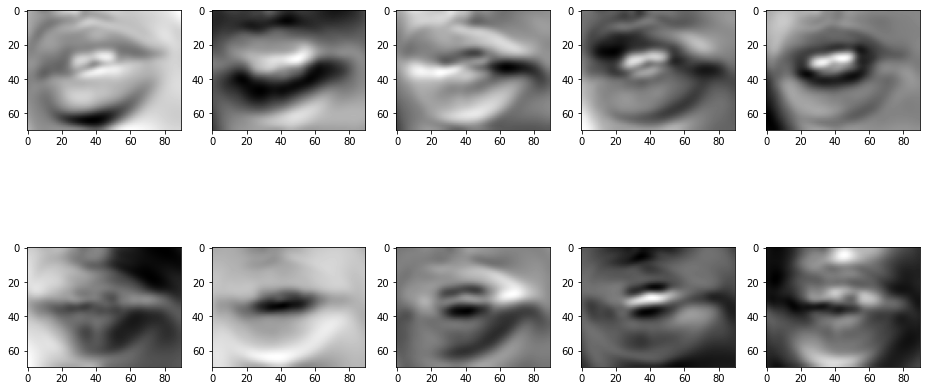

In [ ]:
display_eigenfaces(pca, 10)

## PCA & MFCC Search

In [ ]:
#source: https://stackoverflow.com/questions/464864/how-to-get-all-possible-combinations-of-a-list-s-elements
#get all possible combinations of pca components
weight_combs = []
weight_idx = list(np.arange(0, 15, 1))
for L in range(len(weight_idx) + 1):
    for subset in itertools.combinations(weight_idx, L):
        weight_combs.append(subset)

In [ ]:
#load the metadata
metadata = pd.read_csv('/content/drive/MyDrive/DeepFakeDetection/data/FakeAVCeleb_v1.2/meta_data.csv')
metadata = metadata[(metadata['method']=='real') | (metadata['method']=='wav2lip')]
metadata = metadata.rename(columns={'Unnamed: 9':'full_path'})
metadata['full_path'] = metadata['full_path'].str.replace('FakeAVCeleb/', '/content/drive/MyDrive/DeepFakeDetection/data/FakeAVCeleb_v1.2/')
metadata['full_path'] = metadata['full_path'] + '/' + metadata['path']
metadata = metadata[(metadata['gender']=='men') & (metadata['race']=='African')]

#generate the training & testing ids
training_ids = np.random.choice(metadata.source.unique(), int(metadata.source.unique().shape[0]*0.8), replace=False)
testing_ids = np.array(metadata[~metadata['source'].isin(training_ids)]['source'].unique())

#get the training details
print('\nLoading Training Details')
training_details = load_FakeAvCeleb_mfcc_lip_data(metadata, training_ids, 'real', debug_mode=False)

#run PCA & generate X & Y
print('\nRunning PCA & Generating Training X & y')
X_train, y_train, lips_data_mean, pca, train_lips_data = generate_mfcc_pca_lips_X_y_data(training_details, True, num_components=15, debug_mode=False)

#fit training models
print('\nFitting Models')
model_versions = []
for idx, weight_comb in enumerate(weight_combs[1:]):
  print(f'Model {idx+1} of {len(weight_combs[1:])}')
  models = train_models(X_train[:, weight_comb], y_train, 'LinearRegression')
  model_versions.append(models)

#get testing details (1 real video, 1 fake video)
print('\nLoading Real Testing Details')
real_testing_details = load_FakeAvCeleb_mfcc_lip_data(metadata, testing_ids, 'real', debug_mode=False)
print('\nLoading Fake Testing Details')
fake_testing_details = load_FakeAvCeleb_mfcc_lip_data(metadata, testing_ids, 'wav2lip', sample=True, debug_mode=False)

#sns.histplot(fake_video_error, label='Fake', color='blue')
#sns.histplot(real_video_error, label='Real', color='red')
#plt.legend()
#plt.show()

Streaming output truncated to the last 5000 lines.
Model 27794 of 32767
Model 27795 of 32767
Model 27796 of 32767
Model 27797 of 32767
Model 27798 of 32767
Model 27799 of 32767
Model 27800 of 32767
Model 27801 of 32767
Model 27802 of 32767
Model 27803 of 32767
Model 27804 of 32767
Model 27805 of 32767
Model 27806 of 32767
Model 27807 of 32767
Model 27808 of 32767
Model 27809 of 32767
Model 27810 of 32767
Model 27811 of 32767
Model 27812 of 32767
Model 27813 of 32767
Model 27814 of 32767
Model 27815 of 32767
Model 27816 of 32767
Model 27817 of 32767
Model 27818 of 32767
Model 27819 of 32767
Model 27820 of 32767
Model 27821 of 32767
Model 27822 of 32767
Model 27823 of 32767
Model 27824 of 32767
Model 27825 of 32767
Model 27826 of 32767
Model 27827 of 32767
Model 27828 of 32767
Model 27829 of 32767
Model 27830 of 32767
Model 27831 of 32767
Model 27832 of 32767
Model 27833 of 32767
Model 27834 of 32767
Model 27835 of 32767
Model 27836 of 32767
Model 27837 of 32767
Model 27838 of 32767
Mode

In [ ]:
# evaluate testing
print('\nEvaluating Testing Details')
error_log_real = []
error_log_fake = []
for idx, models in enumerate(model_versions):
  print(f'Evaluating Model {idx+1} of {len(model_versions)}')
  real_video_error, fake_video_error = eval_test_data(real_testing_details, fake_testing_details, models, lips_data_mean, pca, components=weight_combs[idx+1], debug_mode=False)
  error_log_real.append(real_video_error)
  error_log_fake.append(fake_video_error)


Evaluating Testing Details
Evaluating Model 1 of 32767
Evaluating Model 2 of 32767
Evaluating Model 3 of 32767
Evaluating Model 4 of 32767
Evaluating Model 5 of 32767
Evaluating Model 6 of 32767
Evaluating Model 7 of 32767
Evaluating Model 8 of 32767
Evaluating Model 9 of 32767
Evaluating Model 10 of 32767
Evaluating Model 11 of 32767
Evaluating Model 12 of 32767
Evaluating Model 13 of 32767
Evaluating Model 14 of 32767
Evaluating Model 15 of 32767
Evaluating Model 16 of 32767
Evaluating Model 17 of 32767
Evaluating Model 18 of 32767
Evaluating Model 19 of 32767
Evaluating Model 20 of 32767
Evaluating Model 21 of 32767
Evaluating Model 22 of 32767
Evaluating Model 23 of 32767
Evaluating Model 24 of 32767
Evaluating Model 25 of 32767
Evaluating Model 26 of 32767
Evaluating Model 27 of 32767
Evaluating Model 28 of 32767
Evaluating Model 29 of 32767
Evaluating Model 30 of 32767
Evaluating Model 31 of 32767
Evaluating Model 32 of 32767
Evaluating Model 33 of 32767
Evaluating Model 34 of 3

In [ ]:
'''
def evaluate(X_test, y_):
  X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.15, random_state=12)

  model = LinearRegression()
  model.fit(X_train, y_train)

  pred = model.predict(X_test)
  err = np.sqrt(mean_squared_error(y_true=y_test, y_pred=pred))/len(pred)

  return pred, err
'''


In [ ]:
import itertools
comb = []
stuff = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15]
for L in range(len(stuff) + 1):
    for subset in itertools.combinations(stuff, L):
        comb.append(subset)

In [ ]:
len(comb)*20